# IMPORT

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import japanize_matplotlib

from pathlib import Path

In [4]:
INPUT = Path('../input')
COMPETITIONS = INPUT / Path('walmart-recruiting-store-sales-forecasting')

In [5]:
features = pd.read_csv(COMPETITIONS / 'features.csv.zip')
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [6]:
stores = pd.read_csv(COMPETITIONS / 'stores.csv')
stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [7]:
sample = pd.read_csv(COMPETITIONS / 'sampleSubmission.csv.zip')
sample.tail()

,Id,Weekly_Sales
115059,45_98_2013-06-28,0
115060,45_98_2013-07-05,0
115061,45_98_2013-07-12,0
115062,45_98_2013-07-19,0
115063,45_98_2013-07-26,0


# ADD FEATURES

In [8]:
features['Date'] = features['Date'].astype('datetime64[ns]')
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['dayofweek'] = features['Date'].dt.dayofweek

# EDA

In [9]:
features['year'].value_counts()

year
2011    2340
2012    2340
2010    2160
2013    1350
Name: count, dtype: int64

In [10]:
features[['Store', 'Fuel_Price']].groupby('Store').mean().tail()

,Fuel_Price
Store,
41,3.294401
42,3.615648
43,3.259242
44,3.328764
45,3.476412


In [11]:
for col in ['year', 'month', 'dayofweek']:
    print(col ,': ' , np.sort(features[col].unique()))

year :  [2010 2011 2012 2013]
month :  [ 1  2  3  4  5  6  7  8  9 10 11 12]
dayofweek :  [4]


In [12]:
features[features['Store']==45][['year', 'Fuel_Price']].groupby('year').mean()

,Fuel_Price
year,
2010,2.862854
2011,3.628692
2012,3.766519
2013,3.691300


In [13]:
features[features['Store']==45][['month', 'Fuel_Price']].groupby('month').mean()

,Fuel_Price
month,
1,3.440833
2,3.361063
3,3.561722
4,3.573500
5,3.618353
6,3.490824
7,3.432389
8,3.470154
9,3.482000


In [14]:
features[features['Store']==45][['dayofweek', 'Fuel_Price']].groupby('dayofweek').mean()

,Fuel_Price
dayofweek,
4,3.476412


# VISUALIZE

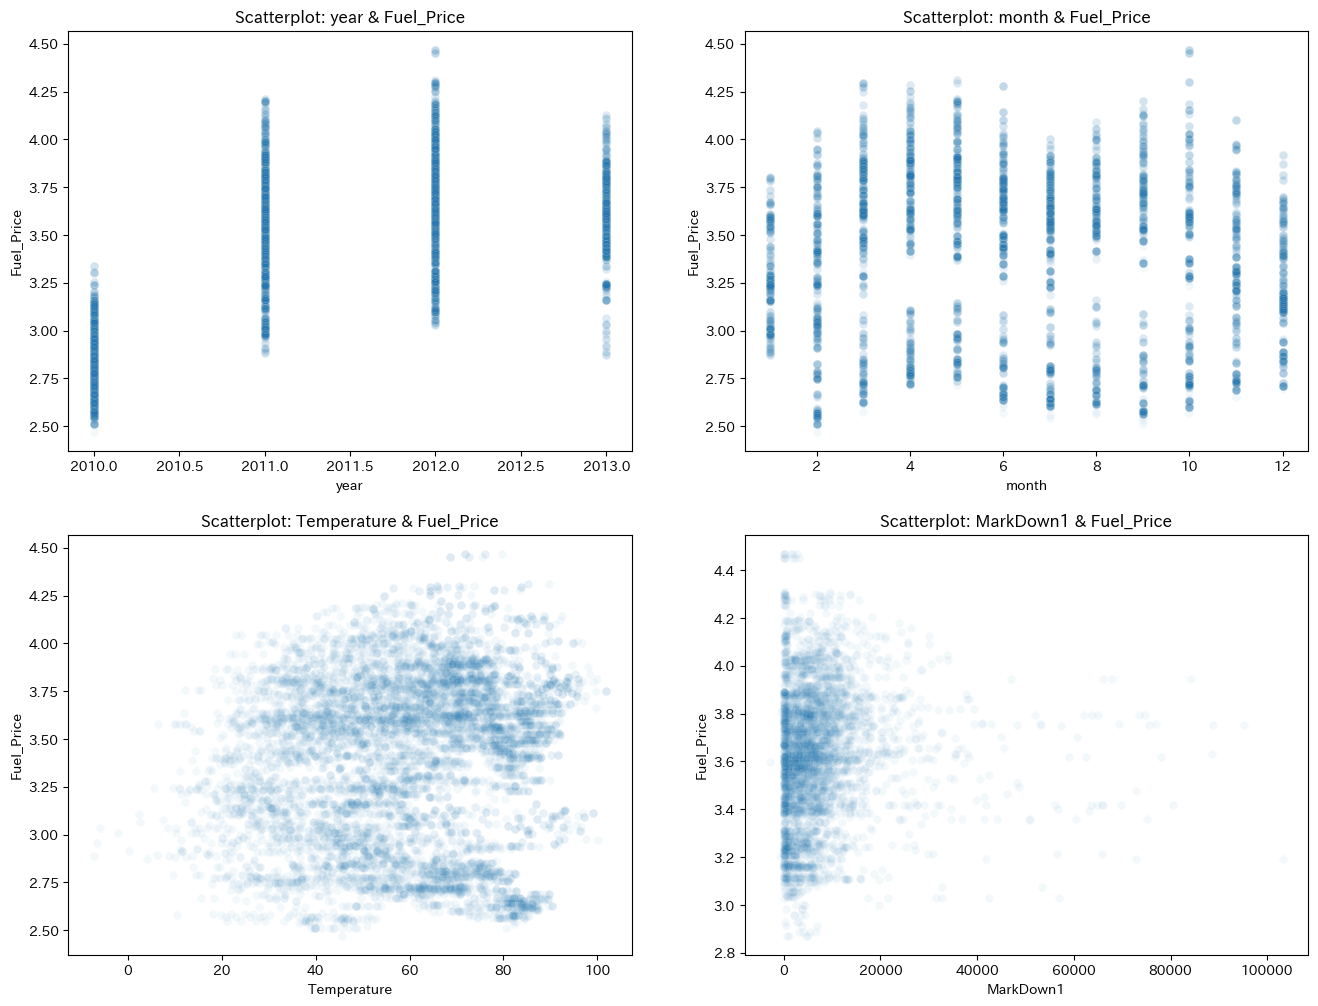

In [21]:
_, axes = plt.subplots(2, 2, figsize=(16,12))
axes = axes.ravel()
for i, col in enumerate(['year', 'month', 'Temperature', 'MarkDown1']):
    sns.scatterplot(data=features, x=col, y='Fuel_Price', alpha=0.05, ax=axes[i]) # hue=**
    # axes[i].legend(loc='upper right')
    axes[i].set_title(f"Scatterplot: {col} & Fuel_Price")
plt.show()